In [76]:
import umap.umap_ as umap
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

train_data = np.load('train_data.npy')
train_labs = np.load('train_labels.npy')
test_data = np.load('test_data.npy')
test_labs = np.load('test_labels.npy')

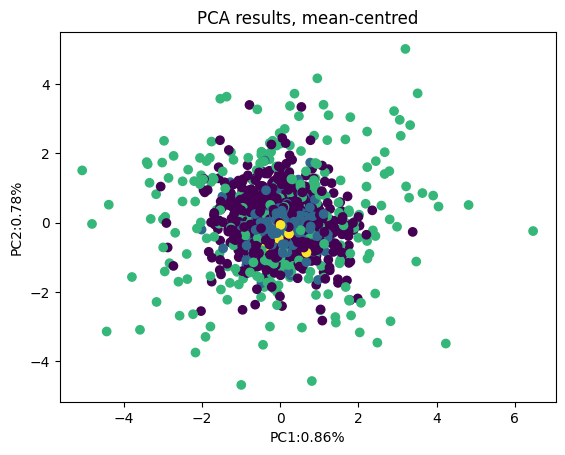

In [77]:
pca = PCA(n_components=2)
scrs = pca.fit_transform(train_data)

plt.scatter(scrs[:,0], scrs[:,1], c=train_labs)
plt.title('PCA results, mean-centred')
plt.xlabel(f'PC1:{pca.explained_variance_ratio_[0]*100:.2f}%')
plt.ylabel(f'PC2:{pca.explained_variance_ratio_[1]*100:.2f}%')
plt.show()

UMAP(min_dist=0.6, n_neighbors=5, verbose=True)
Tue Jan 23 12:02:20 2024 Construct fuzzy simplicial set
Tue Jan 23 12:02:26 2024 Finding Nearest Neighbors
Tue Jan 23 12:02:26 2024 Finished Nearest Neighbor Search
Tue Jan 23 12:02:26 2024 Construct embedding


Epochs completed:  12%| █▏         62/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  38%| ███▊       192/500 [00:01]

	completed  150  /  500 epochs


Epochs completed:  56%| █████▌     278/500 [00:02]

	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  76%| ███████▋   382/500 [00:02]

	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]

	completed  450  /  500 epochs
Tue Jan 23 12:02:29 2024 Finished embedding



Epochs completed: 100%| ██████████ 100/100 [00:01]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


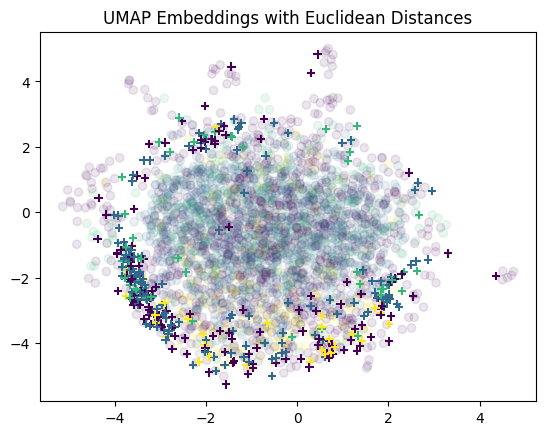

In [78]:
scaler = preprocessing.MinMaxScaler().fit(train_data)

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

reducer_euclidean = umap.UMAP(n_components=2,
                              n_neighbors=5,
                              min_dist=0.6,
                              metric='euclidean',
                              verbose=True)

train_embds = reducer_euclidean.fit(train_data)
test_embds = reducer_euclidean.transform(test_data)

plt.scatter(train_embds.embedding_[:,0],train_embds.embedding_[:,1],c=train_labs,alpha=0.1)
plt.scatter(test_embds[:,0],test_embds[:,1],c=test_labs,marker='+')
plt.title('UMAP Embeddings with Euclidean Distances')
plt.show()

UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.6, n_neighbors=5, verbose=True)
Tue Jan 23 12:02:32 2024 Construct fuzzy simplicial set
Tue Jan 23 12:03:09 2024 Finding Nearest Neighbors
Tue Jan 23 12:03:09 2024 Finished Nearest Neighbor Search
Tue Jan 23 12:03:09 2024 Construct embedding


Epochs completed:  13%| █▎         66/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  53%| █████▎     265/500 [00:02]

	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed:  65%| ██████▍    324/500 [00:02]

	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:02]

	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jan 23 12:03:12 2024 Finished embedding



Epochs completed: 100%| ██████████ 100/100 [00:01]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


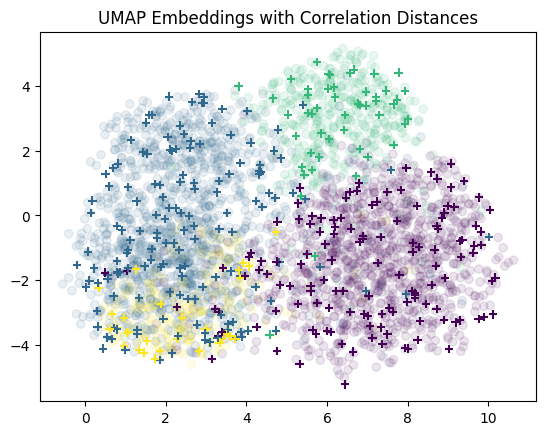

In [79]:
reducer_correlation = umap.UMAP(n_components=2,
                    n_neighbors=5,
                    min_dist=0.6,
                    metric='correlation',
                    verbose=True)

train_embds = reducer_correlation.fit(train_data)
test_embds = reducer_correlation.transform(test_data)

plt.scatter(train_embds.embedding_[:,0],train_embds.embedding_[:,1],c=train_labs,alpha=0.1)
plt.scatter(test_embds[:,0],test_embds[:,1],c=test_labs,marker='+')
plt.title('UMAP Embeddings with Correlation Distances')
plt.show()

Epochs completed: 100%| ██████████ 100/100 [01:24]


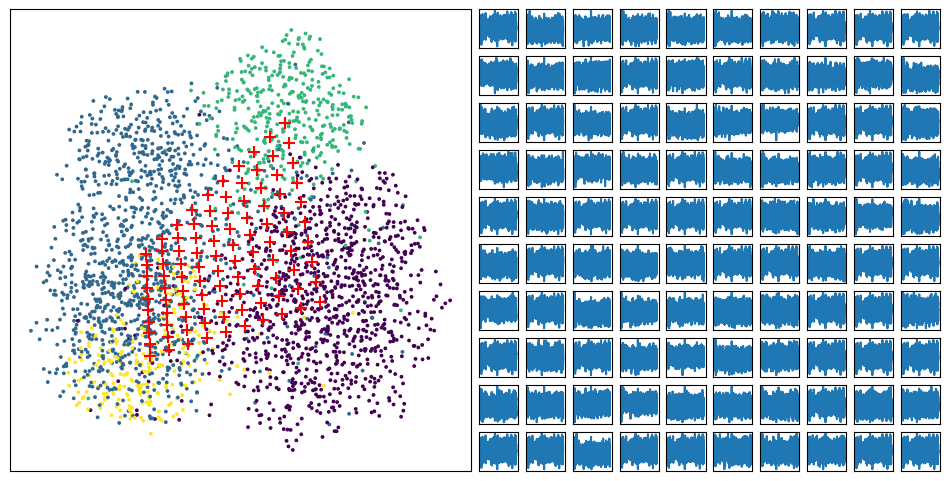

In [80]:
#find means of each class
clusters = np.unique(train_labs)

cluster_means = np.zeros((clusters.shape[0],2))

for cluster in clusters:
    cluster_embeddings = reducer_correlation.embedding_[train_labs == cluster]
    cluster_means[cluster,:] = np.mean(cluster_embeddings,axis=0)

#create convex quadrilateral
centred_coords = cluster_means - np.mean(cluster_means,axis=0)
thetas = np.arctan2(centred_coords[:,1],centred_coords[:,0])
order = np.argsort(thetas)

cluster_means = cluster_means[np.roll(order,1),:]

# adapted from umap-learn.readthedocs.io/en/latest/inverse_transform.html
test_points = np.array([
    (cluster_means[0]*(1-x) + cluster_means[3]*x)*(1-y) +
    (cluster_means[1]*(1-x) + cluster_means[2]*x)*y
    for y in np.linspace(0,1,10)
    for x in np.linspace(0,1,10)
])

#Find the inverse transform of the points and plot them
inv_transformed_points = scaler.inverse_transform(reducer_correlation.inverse_transform(test_points))

# Set up the grid
fig = plt.figure(figsize=(12,6))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

scatter_ax.scatter(reducer_correlation.embedding_[:, 0], reducer_correlation.embedding_[:, 1],
                   c=train_labs, s=3)
scatter_ax.set(xticks=[], yticks=[])

scatter_ax.scatter(test_points[:, 0], test_points[:, 1], marker='+', c='r', s=75)

#plot the inverse transforms
for i in range(10):
    for j in range(10):
        digit_axes[i, j].plot(inv_transformed_points[i*10 + j,:].T)
        digit_axes[i, j].set(xticks=[], yticks=[])

plt.show()